## Data loading and visualization

100%|██████████| 149M/149M [00:01<00:00, 95.9MB/s]

Extracting files...


Train dataset
 Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Test  dataset
 Dataset ImageFolder
    Number of datapoints: 1311
    Root location: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Figure number: 1500  |  Class: 1 - meningioma


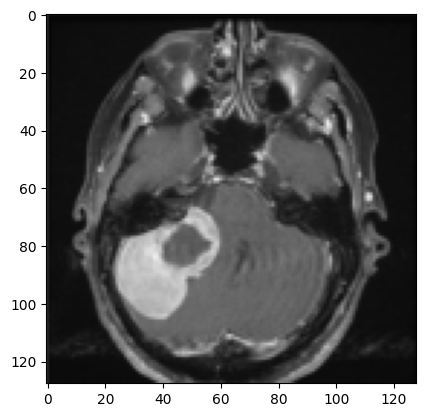

In [2]:
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#Download datasets paths
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

#Data scaler - fix images sizes
scaling = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

#Train-Test splitting
training_dataset_path = dataset_path + "/Training"
test_dataset_path = dataset_path + "/Testing"
train_dataset = datasets.ImageFolder(root = training_dataset_path, transform=scaling)
test_dataset = datasets.ImageFolder(root = test_dataset_path, transform=scaling)
print("Train dataset\n", train_dataset, end='\n\n')
print("Test  dataset\n", test_dataset,  end='\n\n')

#Train-Test Single Dataloader
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

#Show a random image of the train dataset
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

idx = 1500
print(f'Figure number: {idx}  |  Class: {train_dataset[idx][1]} - {train_dataset.classes[train_dataset[idx][1]]}')
imshow(train_dataset[idx][0])


## Data scaling

In [3]:
from sklearn.preprocessing import StandardScaler

#Data setup
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

#Flatten the vectors
train_vectors = train_images.view(len(train_images), -1).numpy()
test_vectors = test_images.view(len(test_images), -1).numpy()

#StandardScale data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_vectors)
test_data = scaler.transform(test_vectors)

print("Shape of train_vectors - scaled:", train_data.shape)
print("Shape of test_vectors  - scaled:", test_data.shape)

Shape of train_vectors - scaled: (5712, 49152)
Shape of test_vectors  - scaled: (1311, 49152)


## PCA Implementation

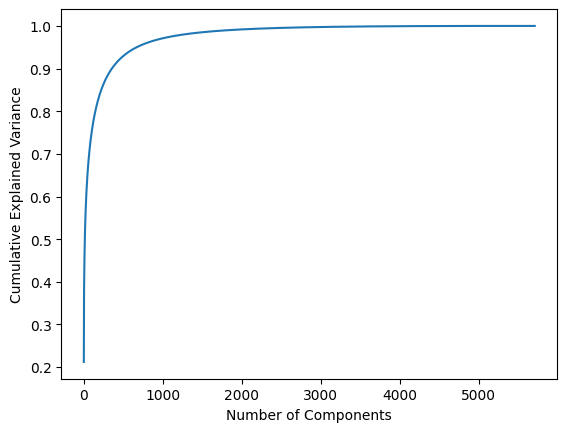

In [4]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(train_data)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

#We can see that from N = 1000 the Explained Variance is no increasing significatively

In [5]:
#Set number of components
n_components = 1000
pca = PCA(n_components=n_components)

#REduce dimensionality
train_pca = pca.fit_transform(train_data)
test_pca = pca.transform(test_data)

#Newer shapes
print("Reduced train shape:", train_pca.shape)
print("Reduced test shape:", test_pca.shape)


Reduced train shape: (5712, 1000)
Reduced test shape: (1311, 1000)


## Logistic regresion with reduced data

Accuracy: 88.18% 



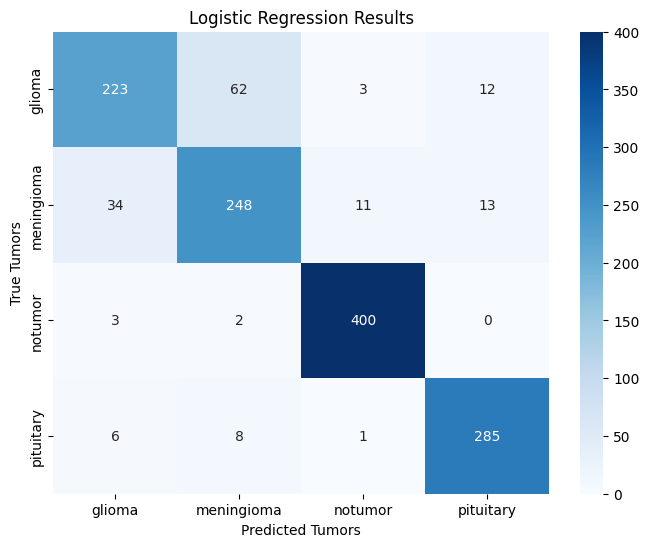

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

#Training
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(train_pca, train_labels)

#Testing
test_predicts = log_reg.predict(test_pca)
accuracy = accuracy_score(test_labels, test_predicts)

#Printing
print(f"Accuracy: {np.round(100*accuracy, 2)}% \n")

#Plotting
cm = confusion_matrix(test_labels, test_predicts)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Logistic Regression Results')
plt.xlabel('Predicted Tumors')
plt.ylabel('True Tumors')
plt.show()

## Random Forest with Reduced Data

Accuracy: 89.02% 



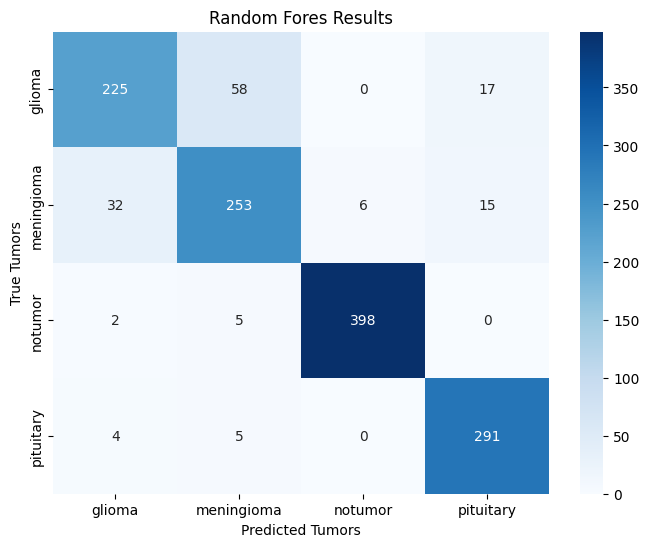

In [13]:
from sklearn.ensemble import RandomForestClassifier

#Implementation
Rand_forst = RandomForestClassifier(n_estimators=100)
Rand_forst.fit(train_pca, train_labels)

#Testing
test_predicts = Rand_forst.predict(test_pca)
accuracy = accuracy_score(test_labels, test_predicts)

#Printing
print(f"Accuracy: {np.round(100*accuracy, 2)}% \n")

#Plotting
cm = confusion_matrix(test_labels, test_predicts)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Random Fores Results')
plt.xlabel('Predicted Tumors')
plt.ylabel('True Tumors')
plt.show()

## FFNN with Reduced Data

In [15]:
#Define the NN
import torch
import torch.nn as nn

class Brain_Tumor_FFNN(nn.Module):
    def __init__(self, input_size = 1000):
        super(Brain_Tumor_FFNN, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        return self.network(x)

In [44]:
from torch.utils.data import TensorDataset, DataLoader

#Definition and optimizer
model = Brain_Tumor_FFNN()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Define dataset in tensor form
train_labels = torch.tensor(train_labels, dtype = torch.long)
test_labels = torch.tensor(test_labels, dtype = torch.long)
train_pca = torch.tensor(train_pca)
test_pca = torch.tensor(test_pca)

#Define tensor dataset
train_dataset = TensorDataset(train_pca, train_labels)
test_dataset = TensorDataset(test_pca, test_labels)

#Define Loaders
bs = 64
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

#Function to train
def train(model, train_loader, test_loader, num_epochs=20):

    #Metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    #Train
    for epoch in range(num_epochs):

        model.train()
        correct, total = 0, 0
        epoch_train_loss = 0

        for data, target in train_loader:

            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            correct += (output.argmax(1) == target).sum().item()
            total += target.size(0)

        train_losses.append(epoch_train_loss / total)
        train_accuracies.append(correct / total)

        #Evaluate during on test set during trainnning
        model.eval()
        epoch_test_loss = 0
        correct, total = 0, 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                loss = loss_function(output, target)
                epoch_test_loss += loss.item()
                correct += (output.argmax(1) == target).sum().item()
                total += target.size(0)

        test_losses.append(epoch_test_loss / total)
        test_accuracies.append(correct / total)

        #Print evolution of the training
        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss = {train_losses[-1]:.6f}, Test Loss = {test_losses[-1]:.6f}, Train Acc = {train_accuracies[-1]:.4f}, Test Acc = {test_accuracies[-1]:.4f}")

    return train_losses, test_losses, train_accuracies, test_accuracies


<ipython-input-44-a4bbe1c6c1d7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype = torch.long)
<ipython-input-44-a4bbe1c6c1d7>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels, dtype = torch.long)
<ipython-input-44-a4bbe1c6c1d7>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_pca = torch.tensor(train_pca)
<ipython-input-44-a4bbe1c6c1d7>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or s

Epoch 1/50: Train Loss = 0.007903, Test Loss = 0.004946, Train Acc = 0.8178, Test Acc = 0.8909
Epoch 2/50: Train Loss = 0.002036, Test Loss = 0.004188, Train Acc = 0.9566, Test Acc = 0.9245
Epoch 3/50: Train Loss = 0.000706, Test Loss = 0.004440, Train Acc = 0.9849, Test Acc = 0.9329
Epoch 4/50: Train Loss = 0.000580, Test Loss = 0.005470, Train Acc = 0.9888, Test Acc = 0.9260
Epoch 5/50: Train Loss = 0.000700, Test Loss = 0.005496, Train Acc = 0.9860, Test Acc = 0.9291
Epoch 6/50: Train Loss = 0.000580, Test Loss = 0.006197, Train Acc = 0.9877, Test Acc = 0.9199
Epoch 7/50: Train Loss = 0.000457, Test Loss = 0.005726, Train Acc = 0.9897, Test Acc = 0.9252
Epoch 8/50: Train Loss = 0.000259, Test Loss = 0.005768, Train Acc = 0.9954, Test Acc = 0.9382
Epoch 9/50: Train Loss = 0.000231, Test Loss = 0.006133, Train Acc = 0.9947, Test Acc = 0.9390
Epoch 10/50: Train Loss = 0.000120, Test Loss = 0.005853, Train Acc = 0.9982, Test Acc = 0.9375
Epoch 11/50: Train Loss = 0.000016, Test Loss = 0

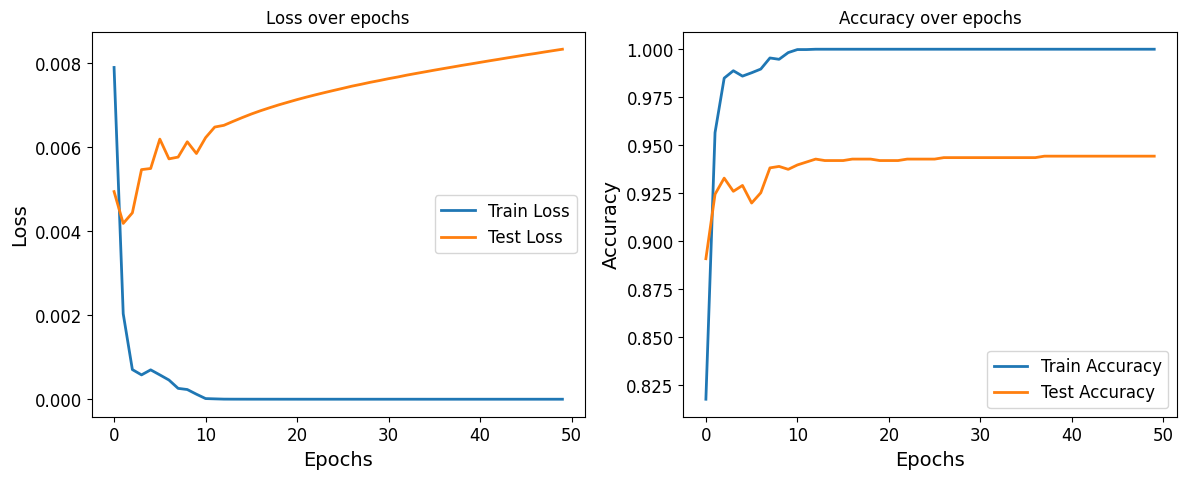

In [45]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, train_loader, test_loader, num_epochs=50)

#Plotting
plt.figure(figsize=(14, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', lw=2)
plt.plot(test_losses, label='Test Loss', lw=2)
plt.title('Loss over epochs')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', lw=2)
plt.plot(test_accuracies, label='Test Accuracy', lw=2)
plt.title('Accuracy over epochs')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.show()


In [30]:
#Analyze the Learning Rate Tunning
import copy

def train_lr(learning_rates, model, train_loader, test_loader, epochs=50):
    results = {}

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")

        #Copy the model
        model_lr = copy.deepcopy(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

        for epoch in range(epochs):
            model.train()
            epoch_train_loss = 0
            correct_train = 0
            total_train = 0

            for batch_data, batch_labels in train_loader:

                optimizer.zero_grad()

                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item() * batch_data.size(0)
                correct_train += (outputs.argmax(dim=1) == batch_labels).sum().item()
                total_train += batch_labels.size(0)

            train_losses.append(epoch_train_loss / total_train)
            train_accuracies.append(correct_train / total_train)

            #Evaluation
            model.eval()
            epoch_test_loss = 0
            correct_test = 0
            total_test = 0

            with torch.no_grad():
                for batch_data, batch_labels in test_loader:

                    outputs = model(batch_data)
                    loss = criterion(outputs, batch_labels)

                    epoch_test_loss += loss.item() * batch_data.size(0)
                    correct_test += (outputs.argmax(dim=1) == batch_labels).sum().item()
                    total_test += batch_labels.size(0)

            test_losses.append(epoch_test_loss / total_test)
            test_accuracies.append(correct_test / total_test)

        #Store results
        results[lr] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies,
        }

    return results

Training with learning rate: 0.0001
Training with learning rate: 0.001
Training with learning rate: 0.01
Training with learning rate: 0.1


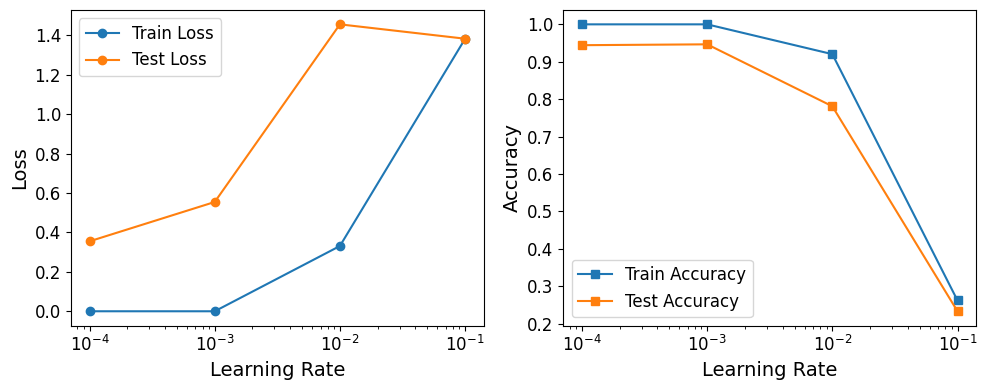

In [40]:
#Run
model = Brain_Tumor_FFNN()
learning_rates = [0.0001, 0.001, 0.01, 0.1]
results = train_lr(learning_rates, model, train_loader, test_loader)

#Extract results
final_train_losses = []
final_test_losses = []
final_train_accuracies = []
final_test_accuracies = []

for lr, res in results.items():
    final_train_losses.append(res['train_losses'][-1])
    final_test_losses.append(res['test_losses'][-1])
    final_train_accuracies.append(res['train_accuracies'][-1])
    final_test_accuracies.append(res['test_accuracies'][-1])

# Create plots
plt.figure(figsize=(10, 4))

#Loss vs Learning Rate
plt.subplot(1, 2, 1)
plt.plot(learning_rates, final_train_losses, marker='o', label='Train Loss')
plt.plot(learning_rates, final_test_losses, marker='o', label='Test Loss')
plt.xscale('log')
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

#Accuracy vs Learning Rate
plt.subplot(1, 2, 2)
plt.plot(learning_rates, final_train_accuracies, marker='s', label='Train Accuracy')
plt.plot(learning_rates, final_test_accuracies, marker='s', label='Test Accuracy')
plt.xscale('log')
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()